# Qiskit 0.44.0 Overview

In [1]:
import qiskit

qiskit.__version__

'0.25.0'

## Final metapackage release

This marks the last release where we refer to the qiskit-metapackage. Starting in this release `pip install qiskit` is only installing
`qiskit-terra`. It no longer includes `qiskit-aer` or the `qiskit-ibmq-provider` (which has been retired and archived now). Starting in
the next release we'll only be referring to `qiskit` and stop using the name `qiskit-terra`. Also there will only one version number in the next release.

## Matplotlib Circuit Visualization support for control flow

Since the introduction of control flow operations to Qiskit visualizing them has always been done as an opaque block with the name of the control flow operation. Starting in Qiskit 0.44.0 the matplotlib based circuit drawer now will visualize the control flow operations a bit better and show the operations in the control flow block. The text drawer will likely support this in the next release.

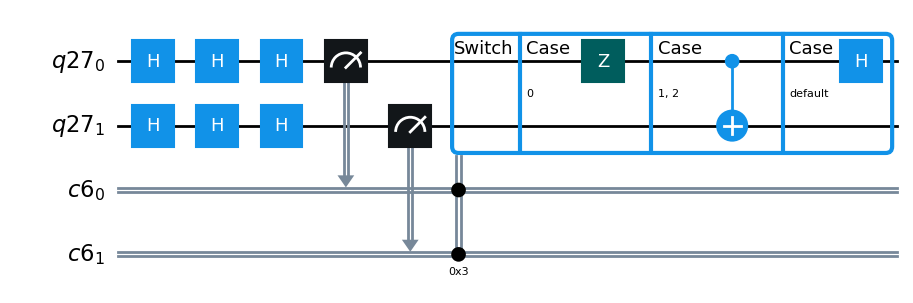

In [15]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile

qreg = QuantumRegister(2)
creg = ClassicalRegister(2)
qc = QuantumCircuit(qreg, creg)

qc.h([0, 1])
qc.h([0, 1])
qc.h([0, 1])
qc.measure([0, 1], [0, 1])
with qc.switch(creg) as case:
  with case(0):  # if the register is '00'
    qc.z(0)
  with case(1, 2):  # if the register is '01' or '10'
    qc.cx(0, 1)
  with case(case.DEFAULT):  # the default case
    qc.h(0)

qc.draw("mpl")      

## Full support for control flow operations through `transpile()`

In Qiskit 0.39.0 we added support to the Qiskit compiler for circuits with control flow operations, but only with optimization levels 0 and 1. This release adds support for level 2 and 3.

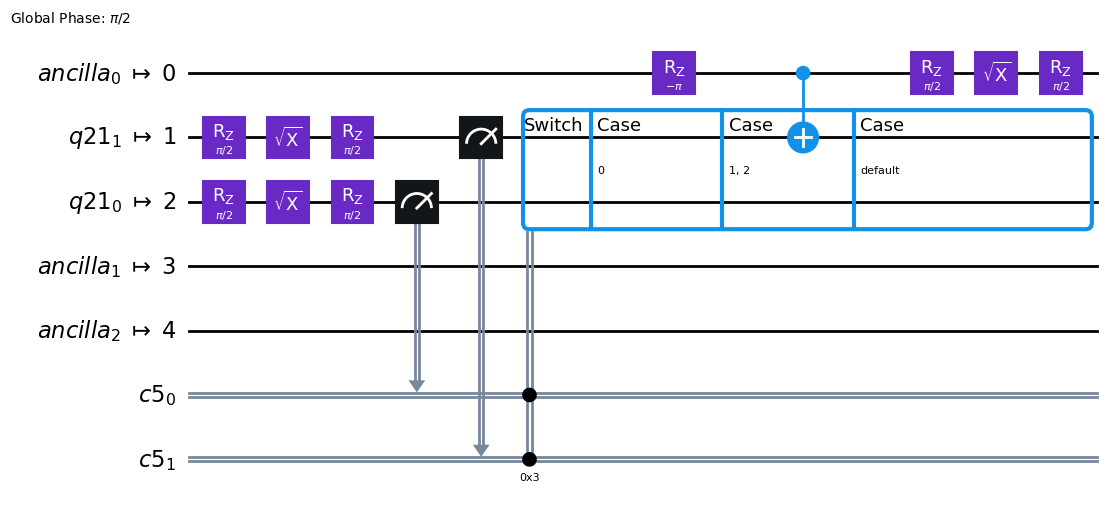

In [14]:
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeBelemV2
from qiskit.circuit import SwitchCaseOp, IfElseOp, WhileLoopOp

backend = FakeBelemV2()
backend.target.add_instruction(SwitchCaseOp, name="switch_case")
backend.target.add_instruction(IfElseOp, name="if_else")
backend.target.add_instruction(WhileLoopOp, name="while_loop")

transpile(qc, backend, optimization_level=2, seed_transpiler=671_44).draw('mpl')

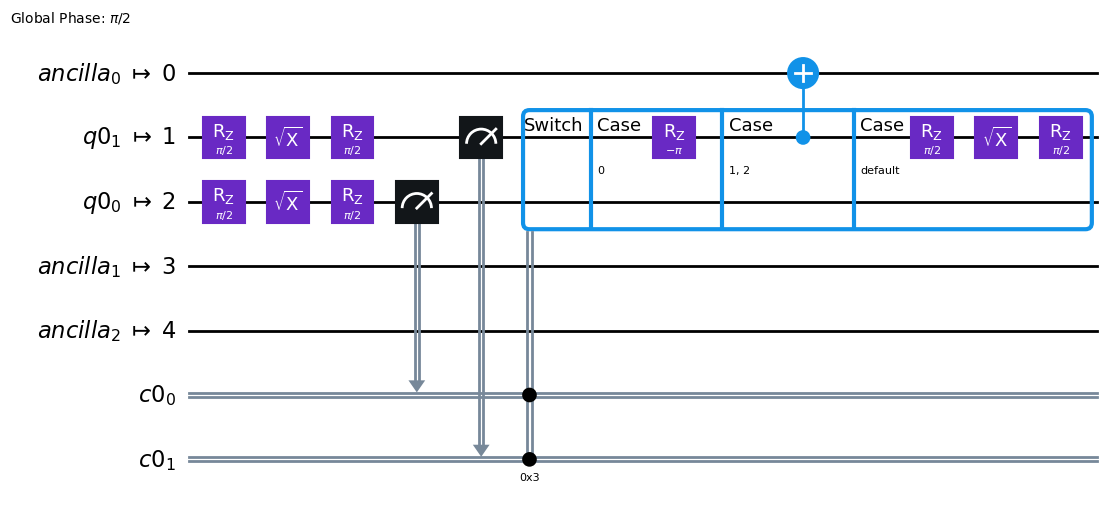

In [4]:
transpile(qc, backend, optimization_level=3, seed_transpiler=671_44).draw('mpl')

## Classical Expression support

This release adds initial support for classical expressions as used in control flow operations. Previously, only register (or bit) equality to a value was supported. In the release this is expanded to support more sophisticated expressions.

The operations supported in classical expression currently are:

 * `bit_not()`
 * `logic_not()`
 * `bit_and()`
 * `bit_or()`
 * `bit_xor()`
 * `logic_and()`
 * `logic_or()`
 * `equal()`
 * `not_equal()`
 * `less()`
 * `less_equal()`
 * `greater()`
 * `greater_equal()`


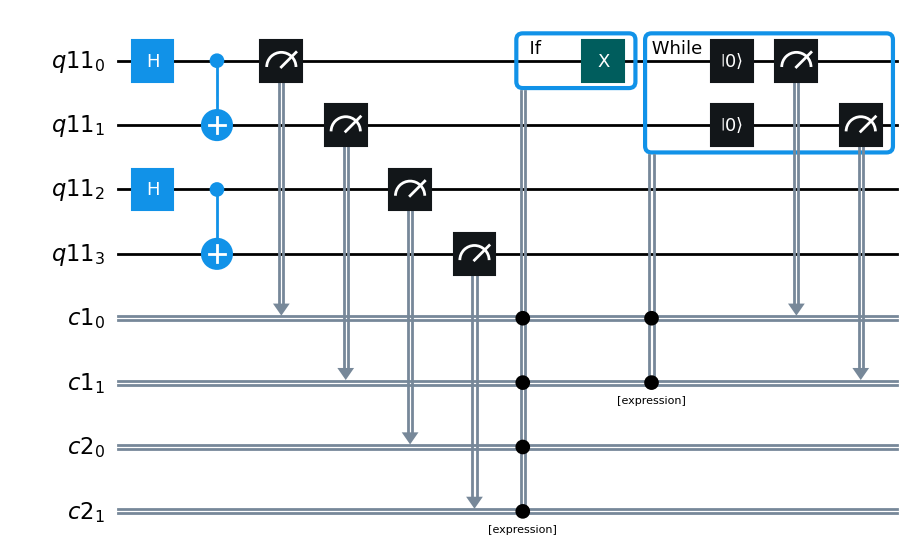

In [5]:
from qiskit.circuit.classical import expr

qr = QuantumRegister(4)
cr1 = ClassicalRegister(2)
cr2 = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr1, cr2)
qc.h(0)
qc.cx(0, 1)
qc.h(2)
qc.cx(2, 3)
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

# If the two registers are equal to each other.
with qc.if_test(expr.equal(cr1, cr2)):
  qc.x(0)

# While either of two bits are set.
with qc.while_loop(expr.logic_or(cr1[0], cr1[1])):
  qc.reset(0)
  qc.reset(1)
  qc.measure([0, 1], cr1)

qc.draw('mpl')

In [6]:
from qiskit.qasm3 import dumps

print(dumps(transpile(qc, backend, optimization_level=3)))

OPENQASM 3;
include "stdgates.inc";
bit[2] c1;
bit[2] c2;
rz(pi/2) $2;
sx $2;
rz(pi/2) $2;
cx $2, $1;
rz(pi/2) $4;
sx $4;
rz(pi/2) $4;
cx $4, $3;
c1[0] = measure $4;
c1[1] = measure $3;
c2[0] = measure $2;
c2[1] = measure $1;
if (c1 == c2) {
  x $4;
}
while (c1[0] || c1[1]) {
  reset $3;
  reset $4;
  c1[0] = measure $4;
  c1[1] = measure $3;
}



## Deprecation Qiskit Algorithms module

The `qiskit.algorithms` module has been deprecated and will be removed in a future Qiskit release. It has been moved to a separate package
`qiskit-algorithms` (https://github.com/qiskit-community/qiskit-algorithms) which is available on PyPI. To migrate you just need to update `qiskit.algorithms` imports to `qiskit-algorithms`.

In [7]:
from qiskit.algorithms import VQE

/tmp/ipykernel_3110804/3311561636.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import VQE


## Performance improvements

### Nested instruction parameter binding

A bugfix in the parameter binding code was made that drastically improved the performance of binding parameters used in the instruction.

In [8]:
import itertools
from math import pi

from qiskit.circuit.library import EfficientSU2
from qiskit.providers.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

circuit = EfficientSU2(127, entanglement='linear', reps=50)

print(f"Number of circuit parameters: {len(circuit.parameters)}")

value_cycle = itertools.cycle([0, pi / 4, pi / 2, 3*pi / 4, pi, 2* pi])
%timeit -n 1 circuit.assign_parameters([x[1] for x in zip(range(len(circuit.parameters)), value_cycle)], inplace=False)

Number of circuit parameters: 12954
526 ms ± 7.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This above example took 146 secs with the 0.40.0 release.

This is a separate plot showing a similar performance comparison binding `EfficientSU2` circuits:

![binding_performance](./image.png)

### Optimization Level 3 performance improvements

Some optimizations were made to compiler passes used primarily in optimization level 3 that improved the performance of the compilation resulting in a ~10-15% runtime improvement:

![OptimizationLevel 3](./opt_level_3.png)